In [31]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using Tensorflow and Keras to predict house prices using a .csv file of house data

![Alt text](https://junwin.github.io/assets/Z01.jpeg)

This walkthrough shows the process of using deep learning to predict house prices using Tensorflow, Keras and a .csv file of sales data.

The topics covered are:

* Loading data from a .csv
* splitting data into training, validation and test sets
* Handling mixed types of data
* Normalising data
* Handling categorical features
* Creating a deep learning model
* Analysing the results
* Storing and reloading models




## Setup

In [32]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import regularizers
#from sklearn import preprocessing
from sklearn.model_selection import train_test_split

## Loading data from a .csv
The size of the sales data is relatively small, so we can process it in memory. We will use a Pandas dataframe to do any manipulation.

In [33]:
url="https://junwin.github.io/data/housepriceclean2.csv"
housePrices=pd.read_csv(url).sample(frac=1)
# We will not process the ClosedDate column - so remove it
housePrices.pop('ClosedDate')
housePrices.head()

,SoldPr,Type,Zip,Area,Rooms,FullBaths,HalfBaths,BsmtBth,Beds,BsmtBeds,GarageSpaces,houseEra
971,615000.000000,Townhouse,60026,3800,9,3,1,No,3.0,0,2.0,20A
3625,385230.698828,SFH,60076,1303,9,3,0,Yes,3.0,0,0.0,19A
2840,369777.318359,SFH,60076,1378,7,2,0,Yes,3.0,0,1.0,19A
8859,287529.796875,SFH,60076,1373,7,2,0,No,3.0,0,2.0,19B
2906,263706.875000,Townhouse,60201,1200,5,1,1,No,2.0,0,1.0,19A


A benefit of using Pandas is that it is easy to experiment with the data, for example, to select some subset while to help understand what affects the accuracy of the model.


In [34]:
#housePrices = housePrices.loc[(housePrices['Zip'] == 60076) & (housePrices['Type'] == 'SFH')]

In our processing, we will treat strings as categories. Although Zip code is numeric, we cannot treat it as a number in the model, so let's convert it to a string.

In [35]:
housePrices['Zip'] = housePrices['Zip'].astype(str) 
housePrices.dtypes

SoldPr          float64
Type             object
Zip              object
Area              int64
Rooms             int64
FullBaths         int64
HalfBaths         int64
BsmtBth          object
Beds            float64
BsmtBeds          int64
GarageSpaces    float64
houseEra         object
dtype: object

We now split the data loaded from the .csv into 
three sets ( training data, validation data and test data).

In [36]:
train, test = train_test_split(housePrices, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')


5988 train examples
1498 validation examples
1872 test examples


Next, we will separate the training and validation dataframes into features and targets and do a rough normalisation of price.

In [37]:
housePrices_features = train.copy()
housePrices_labels = housePrices_features.pop('SoldPr')
housePrices_labels = housePrices_labels/100000

val_features = val.copy()
val_labels = val.pop('SoldPr')
val_labels = val_labels/100000

In [38]:
print(housePrices_features.dtypes)
print(housePrices_labels.dtypes)

Type             object
Zip              object
Area              int64
Rooms             int64
FullBaths         int64
HalfBaths         int64
BsmtBth          object
Beds            float64
BsmtBeds          int64
GarageSpaces    float64
houseEra         object
dtype: object
float64


It is difficult to use the data we have to train a model "as is" because the feature data contains different types and numeric ranges.

It is possible to write code to transform the original dataset; however, we would need to consider deploying the extra code. Second, when using the model to predict a price, we will need to use the same transformations on the data input.

A reasonable solution is to embed any transformations into the model, so it is simple to deploy and use.

Here we will build a model using the Keras functional API the functional API uses symbolic tensors so we will first create a set of these tensors matching the names and types of the feature data.



In [39]:
inputs = {}

for name, column in housePrices_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'Area': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Area')>,
 'Beds': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Beds')>,
 'BsmtBeds': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'BsmtBeds')>,
 'BsmtBth': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'BsmtBth')>,
 'FullBaths': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'FullBaths')>,
 'GarageSpaces': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'GarageSpaces')>,
 'HalfBaths': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'HalfBaths')>,
 'Rooms': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'Rooms')>,
 'Type': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Type')>,
 'Zip': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'Zip')>,
 'houseEra': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'houseEra')>}

We will use Tensorflow's normalization pre-processing for each numeric field. Notice that we call the adapt method with the training data to set up the normaliser before use.

In [40]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = preprocessing.Normalization()
norm.adapt(np.array(housePrices[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'normalization_1')>

Collect all the symbolic preprocessing results, to concatenate them later.

In [41]:
preprocessed_inputs = [all_numeric_inputs]

String fields will first use a StringLookup function to map the strings to their corresponding index in a vocabulary based on the different data strings. Second, using the index and default settings, the Tensorflow's pre-processing category encoding will generate a one-hot vector.

Together with the numeric field handling, we then transform the input data.

In [42]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = preprocessing.StringLookup(vocabulary=np.unique(housePrices_features[name]))
  one_hot = preprocessing.CategoryEncoding(max_tokens=lookup.vocab_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

Given the preprocessed inputs (for normalisation and categorisation) and the corresponding input fields we can build a model the preprocesses the input data. We can visualise the model, as shown below.

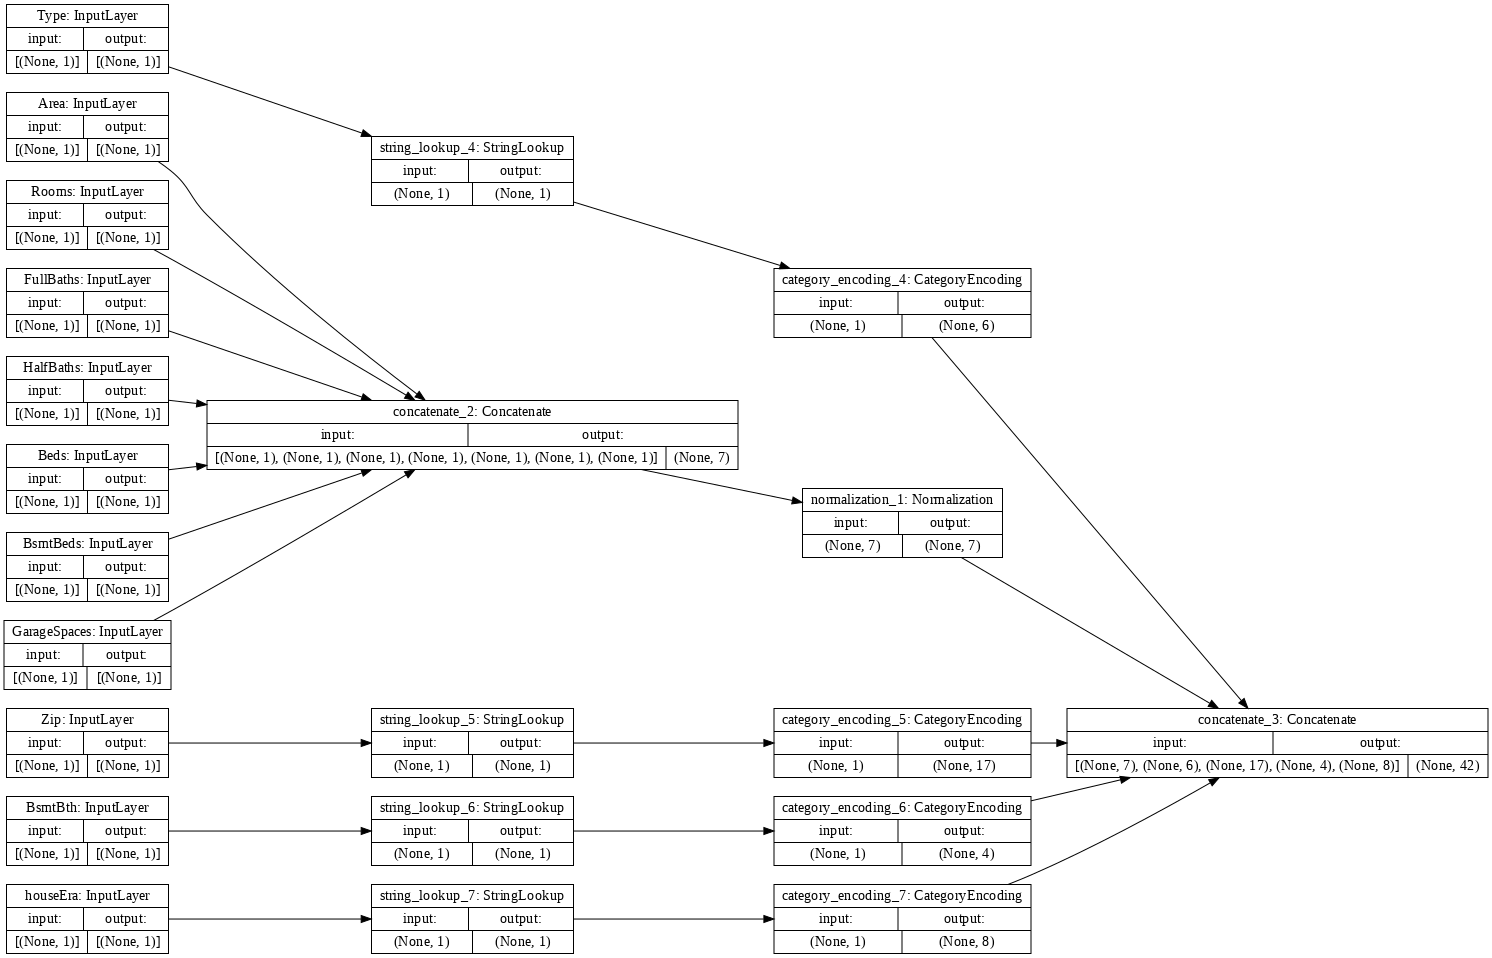

In [43]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

housePrices_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = housePrices_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

This `model` just contains the input preprocessing. You can run it to see what it does to your data. Keras models don't automatically convert Pandas `DataFrames` because it's not clear if it should be converted to one tensor or to a dictionary of tensors. So convert it to a dictionary of tensors:

In [44]:
housePrices_features_dict = {name: np.array(value) 
                         for name, value in housePrices_features.items()}

We can run some sample data through the preprocessing, to validate we are getting the expected results - you should be able to see the normalised data and one-hot vectors.

In [45]:
features_dict = {name:values[:1] for name, values in housePrices_features_dict.items()}
housePrices_preprocessing(features_dict)

<tf.Tensor: shape=(1, 42), dtype=float32, numpy=
array([[-0.388,  0.801, -0.236,  0.767,  0.744, -0.374,  0.243,  0.   ,
         0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         1.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ]], dtype=float32)>

Now build the model based on the Keras functional API  on top of this.
We will typically make changes to the layers defined in the housePrices_model function. In this case, a pipeline is built that takes the inputs, pre-processes them and then uses the main model to make predictions.

In [46]:
def housePrices_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(128,activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(64,activation='relu'),
    #layers.Dense(64,activation='relu'),
    layers.Dense(1)
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss='mse', optimizer='adam', metrics=['mae'])
  return model

housePrices_model = housePrices_model(housePrices_preprocessing, inputs)

When you train the model, pass the dictionary of features as `x`, and the label as `y`.

In [ ]:
val_features_dict = {name: np.array(value) 
                         for name, value in val.items()}
history_1 = housePrices_model.fit(x=housePrices_features_dict, y=housePrices_labels,epochs=250,
                        validation_data=(val_features_dict, val_labels))

It is crucial to visualise the metrics produced during training; this will quickly indicate how quickly the model converges, potential issues of under and overfitting.

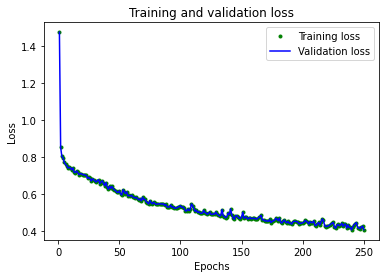

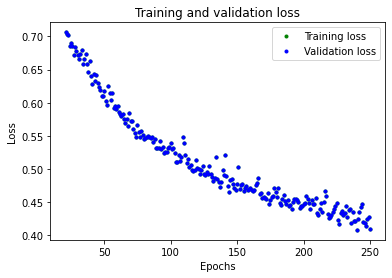

In [48]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
import matplotlib.pyplot as plt
train_loss = history_1.history['mae']
val_loss = history_1.history['mae']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exclude the first few epochs so the graph is easier to read
SKIP = 20

plt.plot(epochs[SKIP:], train_loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

By implementing pre-processing as part of the model, we can now save the model and deploy it elsewhere as a simple package. 

In [49]:
housePrices_model.save('test')
reloaded = tf.keras.models.load_model('test')

INFO:tensorflow:Assets written to: test/assets


In [50]:
! zip -r test.zip test 

updating: test/ (stored 0%)
updating: test/saved_model.pb (deflated 90%)
updating: test/assets/ (stored 0%)
updating: test/variables/ (stored 0%)
updating: test/variables/variables.index (deflated 61%)
updating: test/variables/variables.data-00000-of-00001 (deflated 9%)


In [51]:
features_dict = {name:values[:1] for name, values in housePrices_features_dict.items()}

before = housePrices_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

tf.Tensor([[4.989]], shape=(1, 1), dtype=float32)
tf.Tensor([[4.989]], shape=(1, 1), dtype=float32)


Finally, we can run predictions on our own data.

In [52]:


houseData_own2 = {'Type': np.array(['SFH', 'SFH', 'SFH', 'Condo', 'Condo']),
  'houseEra': np.array(['recent', '19A', '20A', '20A', '19B']),
	'Area': np.array([8410, 1400, 1500, 1500, 1600]),
  'Zip': np.array(['60062', '60062', '60076', '60076', '60202']),
	'Rooms': np.array([16, 6, 7, 7, 7]),
  'FullBaths': np.array([6.0, 2.0, 2.0, 2.5, 2.0]),
  'HalfBaths': np.array([0.0, 1.0, 1.0, 0.0, 0.0]),
  'BsmtBth': np.array(['Yes', 'No', 'No', 'No', 'No']),
  'Beds': np.array([5, 3, 3, 3, 3]),
  'BsmtBeds': np.array([1.0, 0.0, 0.0, 0.0, 0.0]),
  'GarageSpaces': np.array([3, 2, 0, 0, 0])  }

ans = reloaded.predict(houseData_own2)

print(ans)



[[16.131]
 [ 3.849]
 [ 3.732]
 [ 1.724]
 [ 3.364]]
